# Simple model of the Nordic energy market

This model does not include the interaction and thus possible congestion between markets into account. 

#### Imports 

In [187]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

from prepare_country_data import transpose_for_country_code

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Load the data

In [188]:
df = pd.read_csv("data/2023/nordic_energy_data.csv")
#df = df[df['country_code'] == 'DK_1']
#df = df.rename(columns={'DA-price [EUR/MWh]': 'Price'})
#df = df.drop(columns=['Unnamed: 0'])
# df = df.drop(df.columns[[9, 62]], axis=1)

df = transpose_for_country_code(df, 'DK_1')
df = df.rename(columns={'DA-price [EUR/MWh]': 'Price'})

#columns_to_drop = df.columns[8:]
#df = df.drop(columns=columns_to_drop)

df.head()


#df = df[df['country_code'] == "DK_1"]
#df.rename(columns={'Unnamed: 0': 'Time', '0': 'Price'}, inplace=True)

#data_dk1 = data_df[data_df['country_code'] == 'DK_1']
#data_dk1.drop(columns=['Unnamed: 0'])
#data_dk1.rename(columns={'DA-price [EUR/MWh]' : 'Price'})
#data_df_dk2 = data_df[data_df['country_code'] == 'DK_2']
#data_dk = data_df_dk1.merge(data_df_dk2, on='Timestamp', suffixes=('', '_DK_2'))
# data_dk1['Difference DA'] = data_dk1['DA-price [EUR/MWh]'] - data_dk1['DA-price [EUR/MWh]_DK_2']

# Filter for May to July
# data_dk = data_dk1[(data_dk1['Timestamp'] >= '2023-05-01') & (data_dk1['Timestamp'] <= '2023-06-30')]
#data_dk1.head()



,Timestamp,Price,Forecasted Load,Forecasted Generation,Solar,Wind Offshore,Wind Onshore,Cap_to_DK_2,Cap_to_NL,Cap_to_NO_2,...,Cap_to_SE_1_NO_4,Cap_to_SE_2_NO_3,Cap_to_SE_2_NO_4,Cap_to_SE_2_SE_1,Cap_to_SE_3_FI,Cap_to_SE_3_NO_1,Cap_to_SE_3_SE_2,Cap_to_SE_3_SE_4,Cap_to_SE_4_DK_2,Cap_to_SE_4_SE_3
0,2023-01-01 00:00:00,2.01,2135.0,832.0,0.0,75.0,556.0,590.0,700.0,1632.0,...,700.0,600.0,250.0,3300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
1,2023-01-01 01:00:00,1.38,2084.0,974.0,0.0,146.0,639.0,590.0,700.0,1632.0,...,700.0,600.0,250.0,3300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
2,2023-01-01 02:00:00,0.09,2059.0,1165.0,0.0,328.0,735.0,590.0,700.0,1632.0,...,700.0,600.0,250.0,3300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
3,2023-01-01 03:00:00,0.08,2001.0,1437.0,0.0,376.0,870.0,590.0,700.0,1632.0,...,700.0,600.0,250.0,3300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
4,2023-01-01 04:00:00,0.05,1969.0,1517.0,0.0,429.0,1047.0,590.0,700.0,1632.0,...,700.0,600.0,250.0,3300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0


In [189]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 8736
General statistics:


,Price,Forecasted Load,Forecasted Generation,Solar,Wind Offshore,Wind Onshore,Cap_to_DK_2,Cap_to_NL,Cap_to_NO_2,Cap_to_SE_3,...,Cap_to_SE_1_NO_4,Cap_to_SE_2_NO_3,Cap_to_SE_2_NO_4,Cap_to_SE_2_SE_1,Cap_to_SE_3_FI,Cap_to_SE_3_NO_1,Cap_to_SE_3_SE_2,Cap_to_SE_3_SE_4,Cap_to_SE_4_DK_2,Cap_to_SE_4_SE_3
count,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,...,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000
mean,86.781918,2414.186126,2366.157395,218.838141,540.404762,962.715316,573.461538,635.439560,1409.989011,625.686813,...,596.016484,582.692308,201.510989,2938.163919,554.716117,1804.917582,6311.137821,2658.241758,1536.881868,4817.857143
std,48.873980,426.149034,1039.459722,368.155188,327.031949,750.177659,96.593450,169.070428,352.392631,186.671100,...,162.381170,91.286723,84.221785,543.163385,481.909208,608.941948,794.745645,292.999136,330.968235,1092.712724
min,-440.100000,1379.000000,259.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1700.000000,0.000000,0.000000,4100.000000,1600.000000,350.000000,3100.000000
25%,59.937500,2098.000000,1551.000000,0.000000,249.000000,339.000000,590.000000,700.000000,1110.000000,715.000000,...,500.000000,600.000000,150.000000,2500.000000,150.000000,1600.000000,5700.000000,2800.000000,1700.000000,3900.000000
50%,92.020000,2402.000000,2264.000000,6.000000,526.000000,749.000000,590.000000,700.000000,1632.000000,715.000000,...,700.000000,600.000000,250.000000,3300.000000,400.000000,2145.000000,6100.000000,2800.000000,1700.000000,4400.000000
75%,114.742500,2728.250000,3157.000000,292.250000,845.250000,1450.000000,590.000000,700.000000,1632.000000,715.000000,...,700.000000,600.000000,250.000000,3300.000000,1200.000000,2145.000000,7300.000000,2800.000000,1700.000000,6200.000000
max,524.270000,3556.000000,5542.000000,1828.000000,1141.000000,3036.000000,590.000000,700.000000,1680.000000,715.000000,...,700.000000,600.000000,250.000000,3300.000000,1200.000000,2145.000000,7300.000000,2800.000000,1700.000000,6200.000000


In [190]:
# Visualization
# Look for all the headings in the dataset which do not have "Cap" in them
print("Headers without 'Cap' in them:")
headers_without_cap = [x for x in df.columns if 'Cap' not in x]
print(headers_without_cap)

# Create a new DataFrame with columns found in the above line
df_without_cap = df[headers_without_cap]
print(df_without_cap.head())


Headers without 'Cap' in them:
['Timestamp', 'Price', 'Forecasted Load', 'Forecasted Generation', 'Solar', 'Wind Offshore', 'Wind Onshore', 'Forecasted Load_DK_2', 'Forecasted Load_FI', 'Forecasted Load_NO_1', 'Forecasted Load_NO_2', 'Forecasted Load_NO_3', 'Forecasted Load_NO_4', 'Forecasted Load_NO_5', 'Forecasted Load_SE_1', 'Forecasted Load_SE_2', 'Forecasted Load_SE_3', 'Forecasted Load_SE_4', 'Forecasted Generation_DK_2', 'Forecasted Generation_FI', 'Forecasted Generation_NO_1', 'Forecasted Generation_NO_2', 'Forecasted Generation_NO_3', 'Forecasted Generation_NO_4', 'Forecasted Generation_NO_5', 'Forecasted Generation_SE_1', 'Forecasted Generation_SE_2', 'Forecasted Generation_SE_3', 'Forecasted Generation_SE_4', 'Solar_DK_2', 'Solar_FI', 'Solar_SE_1', 'Solar_SE_2', 'Solar_SE_3', 'Solar_SE_4', 'Wind Offshore_DK_2', 'Wind Onshore_DK_2', 'Wind Onshore_FI', 'Wind Onshore_NO_1', 'Wind Onshore_NO_2', 'Wind Onshore_NO_3', 'Wind Onshore_NO_4', 'Wind Onshore_SE_1', 'Wind Onshore_SE_2', 

In [203]:
# convert data to a matrix
y = df['Price'].values
x = df_without_cap[df_without_cap.columns[2::]].values


x = x[2:]
N,D = x.shape
T = len(y)
print("T=%d" % (T))
print("N=%d, D=%d" % (N,D))

x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)
x = (x - x_mean) / x_std

y_true_mean = np.mean(y)
y_true_std = np.std(y)
y = (y - y_true_mean) / y_true_std


T=8736
N=8734, D=44


In [204]:
#print the column headlings in x
print("Column headings in x:")
print(df.columns[2:8])
print(df.columns[34:54])

Column headings in x:
Index(['Forecasted Load', 'Forecasted Generation', 'Solar', 'Wind Offshore',
       'Wind Onshore', 'Cap_to_DK_2'],
      dtype='object')
Index(['Solar_FI', 'Solar_SE_1', 'Solar_SE_2', 'Solar_SE_3', 'Solar_SE_4',
       'Wind Offshore_DK_2', 'Wind Onshore_DK_2', 'Wind Onshore_FI',
       'Wind Onshore_NO_1', 'Wind Onshore_NO_2', 'Wind Onshore_NO_3',
       'Wind Onshore_NO_4', 'Wind Onshore_SE_1', 'Wind Onshore_SE_2',
       'Wind Onshore_SE_3', 'Wind Onshore_SE_4', 'Cap_to_DE_LU_DK_2',
       'Cap_to_DE_LU_NO_2', 'Cap_to_DE_LU_SE_4', 'Cap_to_DK_1_DK_2'],
      dtype='object')


In [205]:

#make ix_mis1 be the last 2000 indexes from x
ix_mis1 = np.arange(T - 2000, T)
ix_obs1 = np.arange(T - 2000)

T_obs = len(ix_obs1)
T_mis = len(ix_mis1)
T = T_obs + T_mis
print("T_obs:", T_obs)
print("T_mis:", T_mis)
print(N)

T_obs: 6736
T_mis: 2000
8734


In [206]:
print(ix_mis1)
print(T)
print(x.shape)

[6736 6737 6738 ... 8733 8734 8735]
8736
(8734, 44)


In [207]:
"""
B = np.random.normal(0,1.)
W = np.random.normal(0.,1., size=D)
h_prev = np.random.normal(0., 1)
tau = np.random.normal(0., 0.1)
carry = (B, W, h_prev, tau)

noises = np.random.normal(0., 1, size=T+100)
input_t = (x_t, noises)

h = lax.scan(f, carry, input_t, T+100)
carry_t, h_t = h

print(h_t.shape)
"""

'\nB = np.random.normal(0,1.)\nW = np.random.normal(0.,1., size=D)\nh_prev = np.random.normal(0., 1)\ntau = np.random.normal(0., 0.1)\ncarry = (B, W, h_prev, tau)\n\nnoises = np.random.normal(0., 1, size=T+100)\ninput_t = (x_t, noises)\n\nh = lax.scan(f, carry, input_t, T+100)\ncarry_t, h_t = h\n\nprint(h_t.shape)\n'

Define carry function for `jax.lax.scan`

In [208]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    B1, B2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = B1*h_prev1 + B2*h_prev2 + jnp.matmul(W, x_t) + tau*noise_t
    h_prev1 = h_t
    h_prev2 = h_prev1
    
    return (B1,B2, W, h_prev1,h_prev2, tau), h_t

Define the NumPyro model

In [209]:
def model(T, T_forecast, x_t, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    B1 = numpyro.sample("B1", dist.Normal(loc=0., scale=1.))
    B2 = numpyro.sample("B2", dist.Normal(loc=0., scale=1.))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros(D), scale=jnp.ones(D)))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=.1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("z_1", dist.Normal(loc=0., scale=.1))
    h_prev2 = numpyro.sample("z_2", dist.Normal(loc=0., scale=.1))

    noises_t = numpyro.sample("noises_t", dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (B1,B2, W, h_prev1,h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    # Sample observed and missing values
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_mis", dist.Normal(loc=h_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_obs", dist.Normal(loc=h_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return h_collection

In [210]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=0, x_t=x, obs=y, ix_mis=ix_mis1, ix_obs=ix_obs1)


sample: 100%|██████████| 2000/2000 [31:30<00:00,  1.06it/s, 1023 steps of size 2.00e-04. acc. prob=0.93] 


In [211]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
            B1     -0.26      0.31     -0.26     -0.79      0.16     12.85      1.17
            B2      0.98      0.30      0.98      0.55      1.51     12.89      1.16
          W[0]      0.10      0.00      0.10      0.10      0.10     16.73      1.00
          W[1]      0.15      0.00      0.15      0.15      0.16      5.94      1.00
          W[2]     -0.04      0.00     -0.04     -0.05     -0.04     18.06      1.06
          W[3]     -0.07      0.00     -0.07     -0.07     -0.07      5.04      1.04
          W[4]     -0.15      0.00     -0.15     -0.16     -0.15      7.20      1.16
          W[5]      0.06      0.00      0.06      0.05      0.06      3.48      1.71
          W[6]      0.20      0.00      0.20      0.20      0.21     15.82      1.09
          W[7]     -0.06      0.01     -0.06     -0.08     -0.05      3.00      2.18
          W[8]     -0.03      0.00     -0.03     -0.03     -0.02

In [212]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


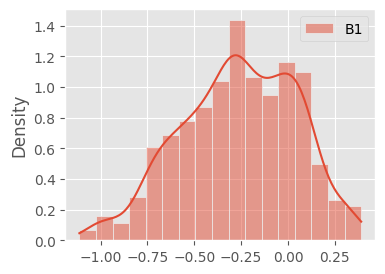

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


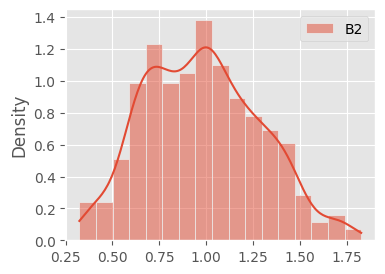

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you w

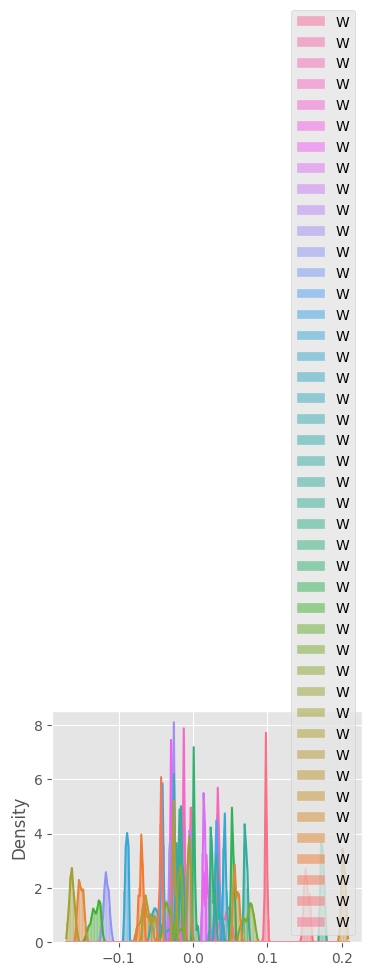

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


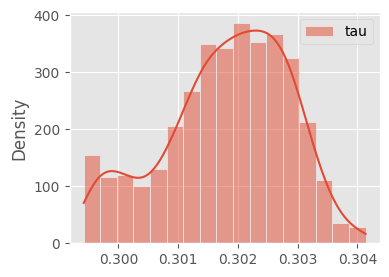

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


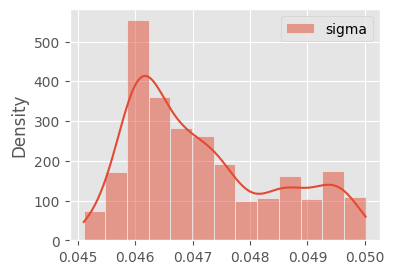

In [213]:
nodes = ["B1","B2", "W", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()

In [214]:
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

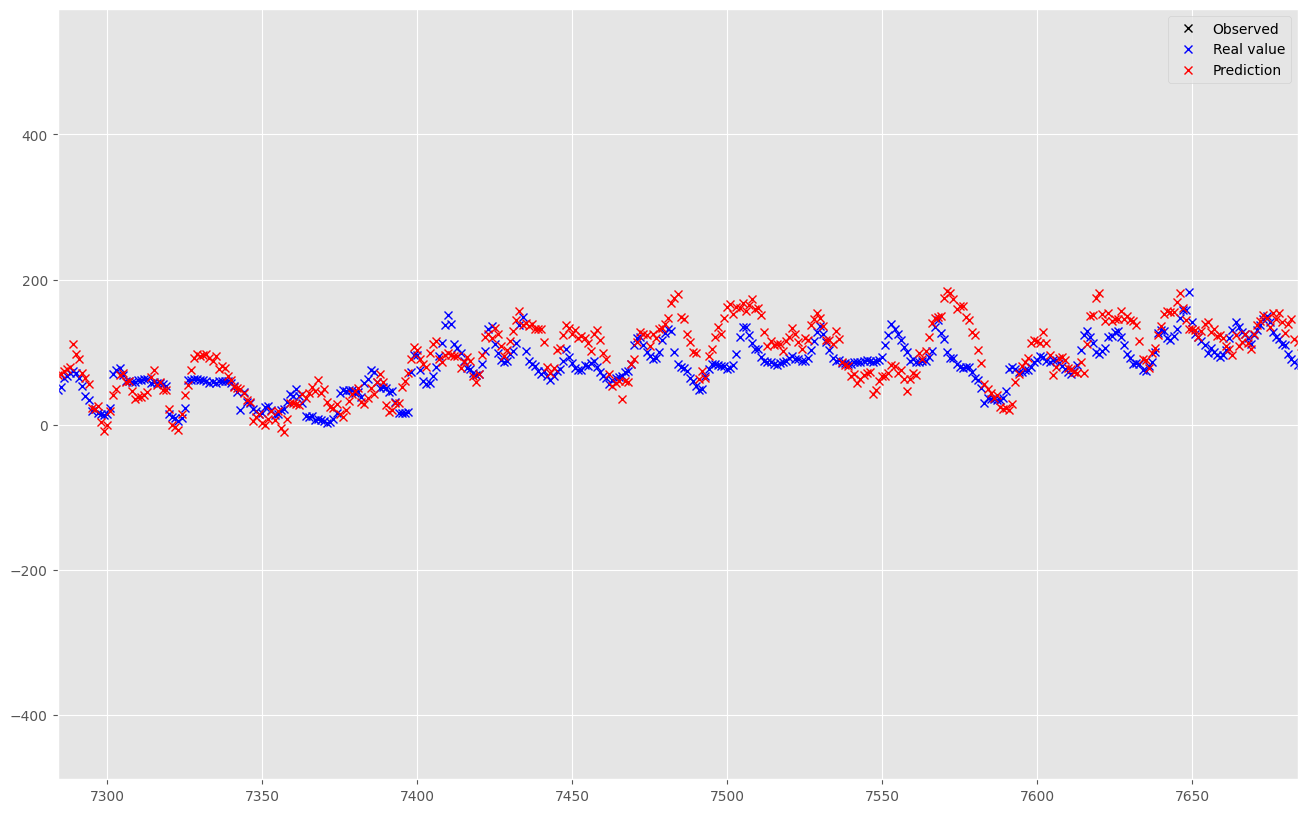

In [216]:
y_obs1 = y[ix_obs1]
y_mis1 = y[ix_mis1]

plt.plot(ix_obs1, (y_obs1*y_true_std) + y_true_mean, "kx")
plt.plot(ix_mis1, (y_mis1*y_true_std) + y_true_mean, "bx")
plt.plot(ix_mis1, (y_hat*y_true_std) + y_true_mean, "rx")
plt.xlim([N-2000+550, N-2000+950])
plt.legend(["Observed", "Real value", "Prediction"])




In [217]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [218]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.784
MAE: 0.58019
RMSE: 0.72663
R2: 0.400


In [ ]:
#values with just taking 5 features
#CorrCoef: 0.697
#MAE: 0.70656
#RMSE: 0.88145
#R2: 0.117

#values with 26 features
#CorrCoef: 0.697
#MAE: 0.70656
#RMSE: 0.88145
#R2: 0.117

#values with all features except Cap
#CorrCoef: 0.784
#MAE: 0.58019
#RMSE: 0.72663
#R2: 0.400

